# Cervical Cancer Screening Algorithm 

By: Ivy Huong Nguyen, Ph.D.

## Introduction 

This capstone project is inspired by a Kaggle competition posted and hosted by [Intel and MobileODT](https://www.kaggle.com/c/intel-mobileodt-cervical-cancer-screening). The main goal of this project is to develop a new algorithm that can effectively identify the type of cervix a patient has based on images. This workflow will help health providers give proper cervical cancer treatment referral to their patients. 

Cervical cancer is classified as a easy-to-prevent cancer if caught in its precancerous stage. According to the American Cancer Society, cervical cancer is one of the most successfully treatable cancers if detected early.  However, one of the most problematic issue in treating patients with this type of cancer is the ability to identify an appropriate treatment that works effectively and accordingly to the patient’s physiological needs. In rural parts of the world, many women who are susceptible to cervical cancer are receiving treatment that will not work due to the position of their cervix. In order to solve this problem, it would be necessary to develop an algorithm that could help health providers identify the type of cervix that a patient has based on images. 


## Data Overview

Here is a summary of all the dataset that are used in building the model for this problem. The description is taken directly from the Kaggle competition website. 

+ train.7z - the training set. The images are organized in their labeled categories: Type_1, Type_2, and Type_3
+ test.7z - the first stage test set. All the images are in this same folder.
+ additional_Type_{x}.7z - Additional images to help train the models. These images sometimes come from duplicated patients, so the images might look alike since they are taken in the same session; while sometimes are cases that aren't selected because of image quality. The images are still labeled. They are organized in their labeled categories: Type_1, Type_2, and Type_3. NOTE: THIS DATA IS UPDATED ON MARCH 27. If you downloaded the previous version of additional.7z, you can download fixed_labels.csv and removed_files.csv to modify files yourself and avoid re-downloading. 
+ test_stg2.7z - the 2nd stage test set. Updated June 15,2017.

##  Data Wrangling 

### Step 1: Create a dataframe with image path and type of cervix image for the training dataset

In [167]:
import warnings
warnings.filterwarnings('ignore')
# import necessary packages for the EDA process
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread, imshow
import cv2

%matplotlib inline

#Obtain list of types avaialble in the train directory
from subprocess import check_output
list_type = check_output(["ls", "train"]).decode("utf8")
list_type = list_type.split('\n')[:-1]

#Initialize empty lists for image directories and image Type
img_dir = []
type_list = []

#Generate a list of directories
for i in list_type:
    img = check_output(["ls", "train/"+i]).decode('utf8')
    img = img.split('\n')[:-1]
    for link in img:
        img_link = 'train/' + i + '/'+link
        img_dir.append(img_link)
        type_list.append(i)

#Create a pandas dataframe of image path and type of image
train = pd.DataFrame({'imagepath':img_dir, 'type': type_list})

In [168]:
# Take a look at the first 5 rows of the training dataframe
train.head()

,imagepath,type
0,train/Type_1/0.jpg,Type_1
1,train/Type_1/1013.jpg,Type_1
2,train/Type_1/1014.jpg,Type_1
3,train/Type_1/1019.jpg,Type_1
4,train/Type_1/1023.jpg,Type_1


In [169]:
# Obtain a quick summary of the dataset
train.describe()

,imagepath,type
count,1481,1481
unique,1481,3
top,train/Type_1/421.jpg,Type_2
freq,1,781


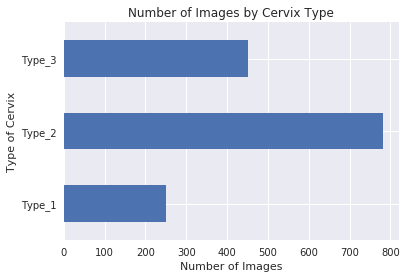

In [170]:
# Generate a horizontal bar plot showing the number of images per cervix type
sns.set()
ax = train.groupby(['type']).agg('count').plot.barh()
ax.set_xlabel('Number of Images')
ax.set_ylabel('Type of Cervix')
ax.set_title('Number of Images by Cervix Type')
ax.legend_.remove()

In [171]:
#Statistical data of number of counts for each type
train.groupby('type').agg('count')

,imagepath
type,
Type_1,250
Type_2,781
Type_3,450


Based on the above analysis, there are 1481 images in total in this training dataset with 250 type_1, 781 type_2, and 450 type_3. 

### Step 2: Visualize the first image of each type of the training dataset

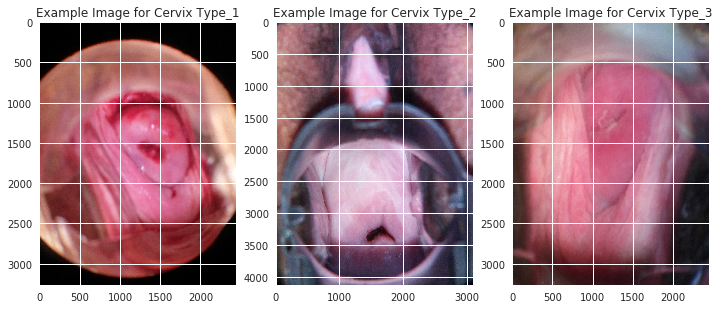

In [173]:
fig = plt.figure(figsize=(12,8))

for i in range(len(list_type)):
    ax=fig.add_subplot(1,3,i+1)
    f = train[train['type']==list_type[i]]['imagepath'].values[0]
    plt.imshow(plt.imread(f))
    plt.title('Example Image for Cervix {}'.format(list_type[i]))

### Step 3: Create a dataframe with image dimensions for each cervix type of the training dataset

In [195]:
#obtain lists of height, width, and channel for all images
heights = []
widths = []
channels = []

for link in img_dir:
    img  = cv2.imread(link)
    height, width, channel = img.shape
    heights.append(height)
    widths.append(width)
    channels.append(channel)

In [196]:
#append three new columns to the current training dataset
train['heights'] = heights
train['widths'] = widths
train['channels'] = channels

In [198]:
#Visualize the first 5 rows of the new training dataset
train.head()

,imagepath,type,heights,widths,channels
0,train/Type_1/0.jpg,Type_1,3264,2448,3
1,train/Type_1/1013.jpg,Type_1,3264,2448,3
2,train/Type_1/1014.jpg,Type_1,4128,3096,3
3,train/Type_1/1019.jpg,Type_1,3264,2448,3
4,train/Type_1/1023.jpg,Type_1,4128,3096,3


In [199]:
#Get a summary statistics of the new training dataset
train.describe()

,heights,widths,channels
count,1481.000000,1481.000000,1481.0
mean,3661.709656,2783.655638,3.0
std,501.958655,384.097922,0.0
min,640.000000,480.000000,3.0
25%,3264.000000,2448.000000,3.0
50%,3264.000000,3096.000000,3.0
75%,4128.000000,3096.000000,3.0
max,4160.000000,4128.000000,3.0


In [201]:
#Convert the new training dataset to a csv file for later use
train.to_csv('training_images_size.csv', sep='\t', encoding='utf-8')

### Step 4: Create a dataframe for the image dimensions of the testing dataset

In [213]:
from glob import glob
list_test = glob('test/*')

height_test = []
width_test = []
channel_test = []
for f in list_test:
    img = cv2.imread(f)
    height, width, channel = img.shape
    height_test.append(height)
    width_test.append(width)
    channel_test.append(channel)

In [215]:
test = pd.DataFrame({'heights': height_test, 'widths': width_test, 'channels': channel_test})
test.to_csv('testing_images_size.csv', sep='\t', encoding='utf-8')